<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy
    - H-L Test for Accuracy by segments (Not done in this notebook)
###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 20,8
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 1440x576 with 0 Axes>

In [4]:
# Load the data
import os
os.chdir('C:\\Users\\Sudhir\\Desktop\\ML Project')
bankloans = pd.read_csv( 'bankloans.csv' )

In [5]:
bankloans.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [6]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [14]:
numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [15]:
bankloans_num=bankloans[numeric_var_names]
bankloans_num.head(5)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [16]:
bankloans_cat = bankloans[cat_var_names]
bankloans_cat.head(5)

""
0
1
2
3
4


In [17]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=bankloans_num.apply(lambda x: var_summary(x)).T

In [18]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [19]:
#Detailed profiling using pandas profiling

pandas_profiling.ProfileReport(bankloans)

Number of variables,9
Number of observations,850
Total Missing (%),2.0%
Total size in memory,59.8 KiB
Average record size in memory,72.1 B
Numeric,9
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [20]:
bankloans_existing = bankloans_num[bankloans_num.default.isnull()==0]
bankloans_new = bankloans_num[bankloans_num.default.isnull()==1]

In [12]:
pandas_profiling.ProfileReport(bankloans_existing) 

Number of variables,9
Number of observations,700
Total Missing (%),0.0%
Total size in memory,54.7 KiB
Average record size in memory,80.0 B
Numeric,8
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [22]:

#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

In [23]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

bankloans_existing=bankloans_existing.apply(lambda x: Missing_imputation(x))

In [24]:
bankloans_existing.corr()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
age,1.000000,0.016582,0.537418,0.596974,0.521540,0.016918,0.308324,0.348906,-0.138663
ed,0.016582,1.000000,-0.158071,0.055553,0.225403,0.009992,0.103026,0.156522,0.118521
employ,0.537418,-0.158071,1.000000,0.324867,0.665488,-0.035339,0.405940,0.419323,-0.287210
address,0.596974,0.055553,0.324867,1.000000,0.345137,0.014971,0.215407,0.234901,-0.165392
income,0.521540,0.225403,0.665488,0.345137,1.000000,-0.022538,0.553006,0.626773,-0.099631
debtinc,0.016918,0.009992,-0.035339,0.014971,-0.022538,1.000000,0.534690,0.603630,0.388556
creddebt,0.308324,0.103026,0.405940,0.215407,0.553006,0.534690,1.000000,0.639947,0.238133
othdebt,0.348906,0.156522,0.419323,0.234901,0.626773,0.603630,0.639947,1.000000,0.138961
default,-0.138663,0.118521,-0.287210,-0.165392,-0.099631,0.388556,0.238133,0.138961,1.000000


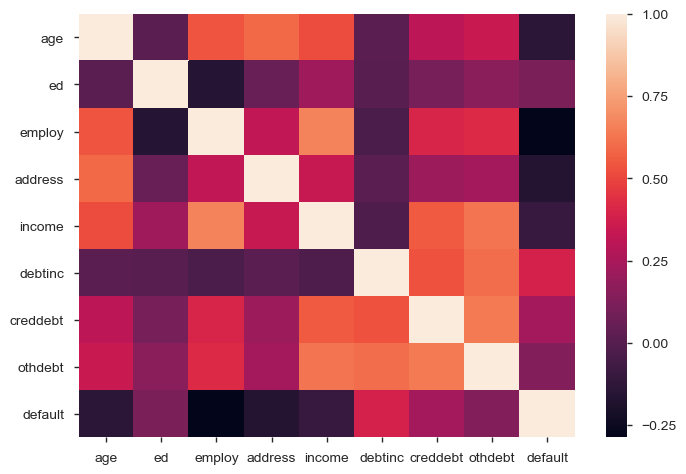

In [26]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bankloans_existing.corr())

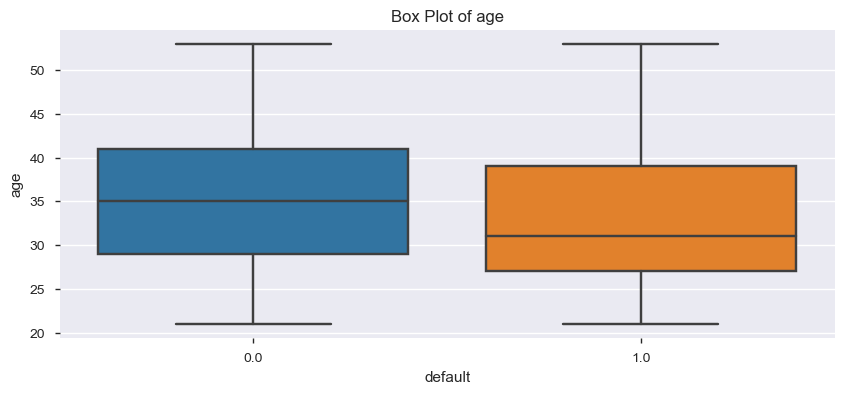

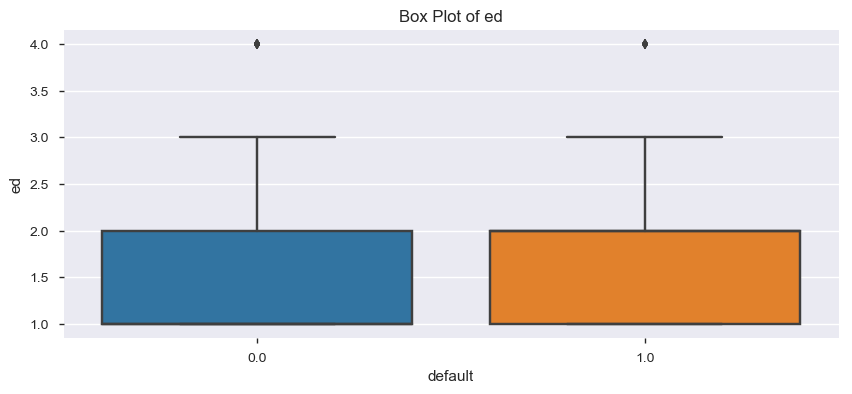

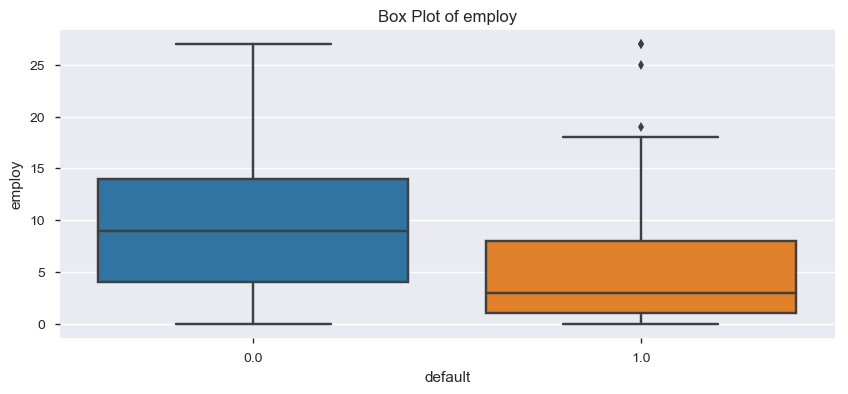

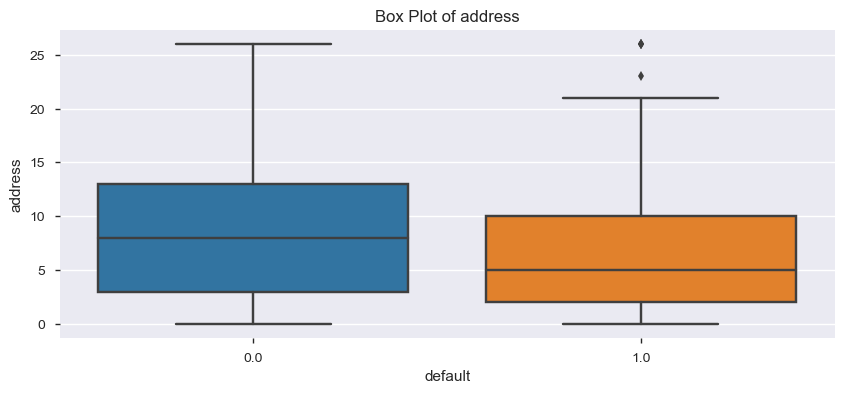

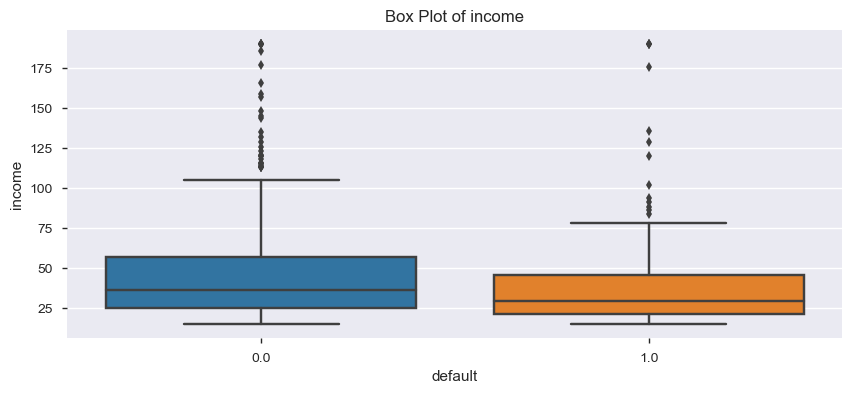

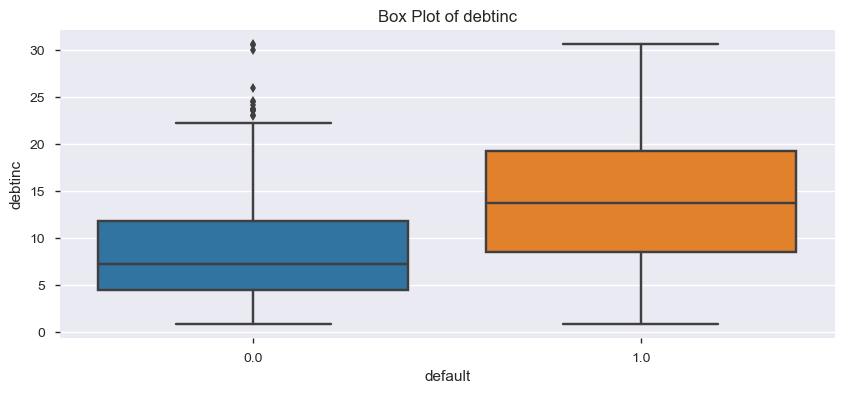

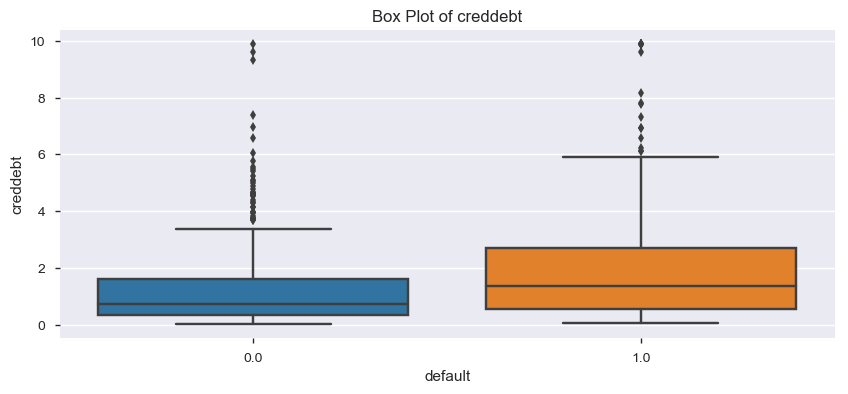

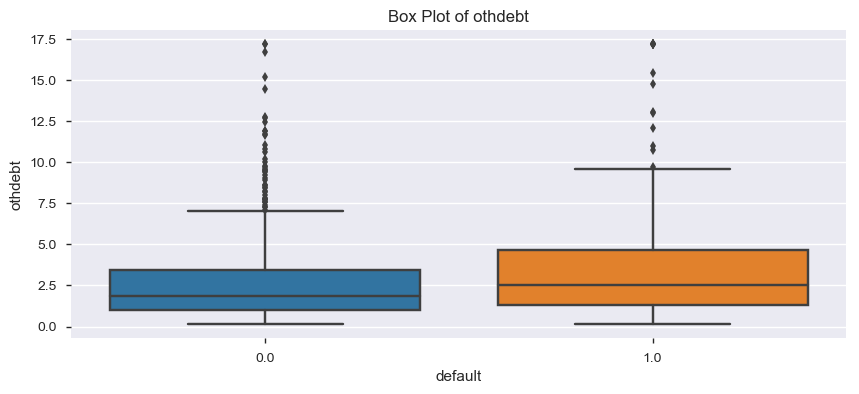

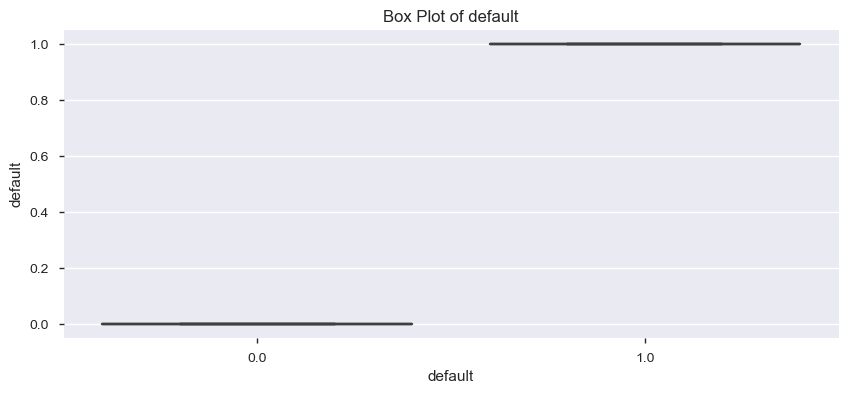

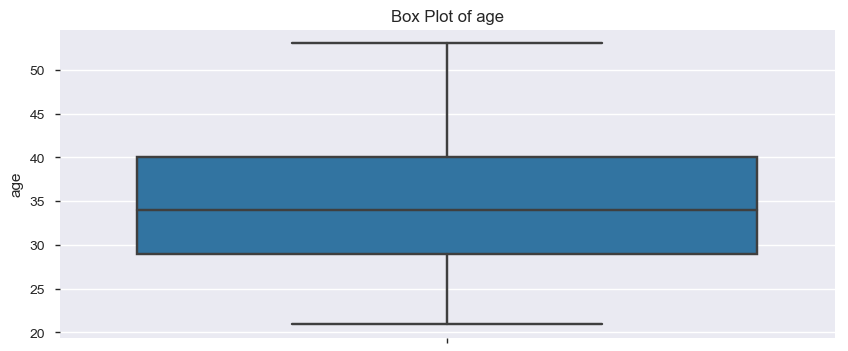

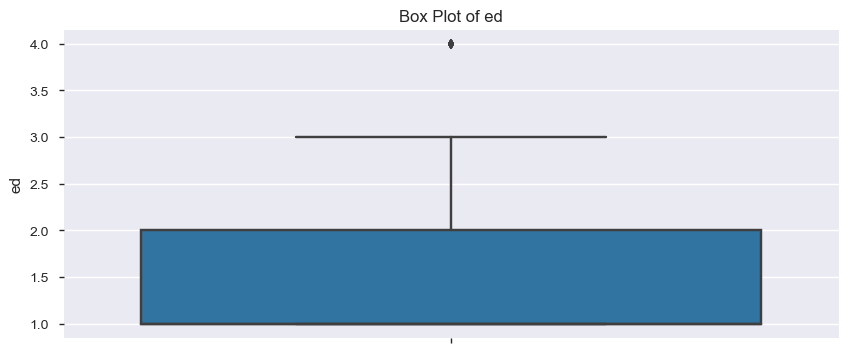

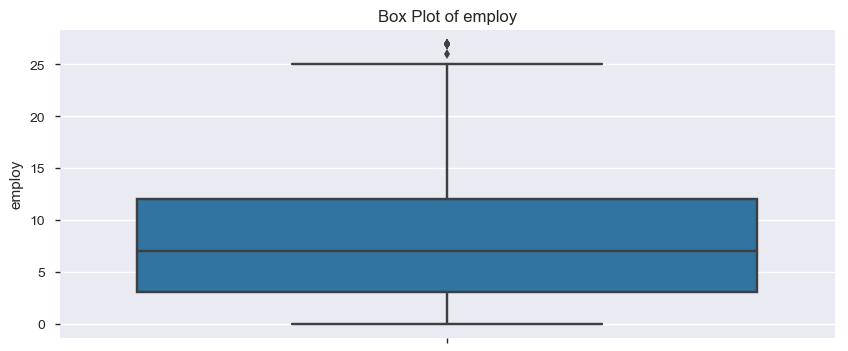

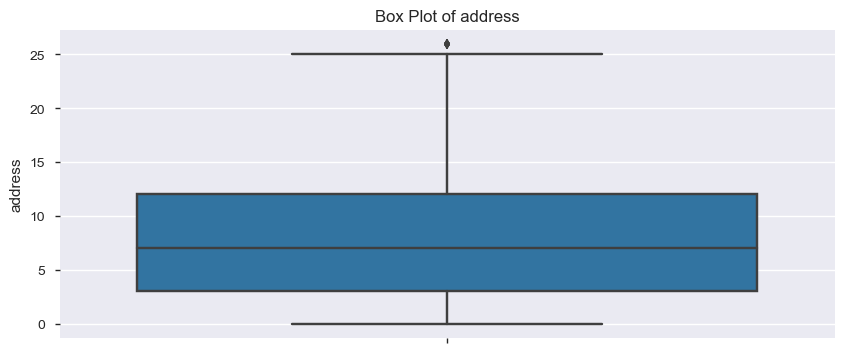

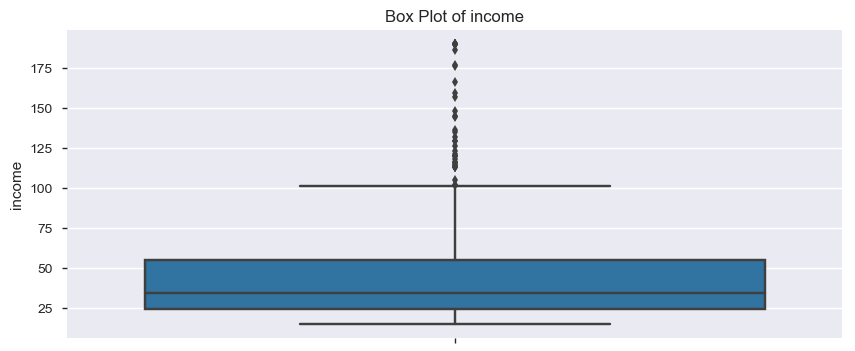

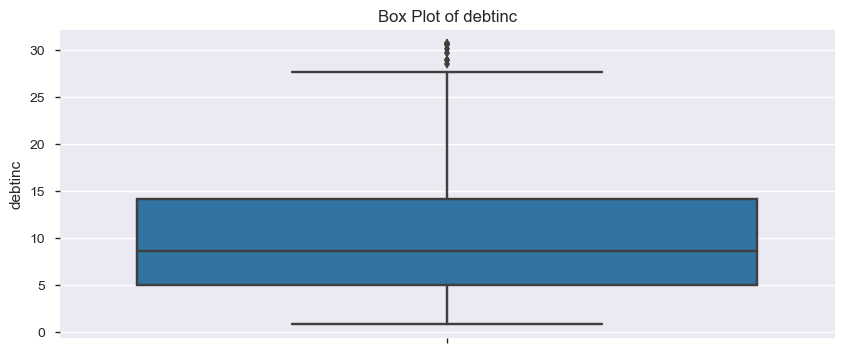

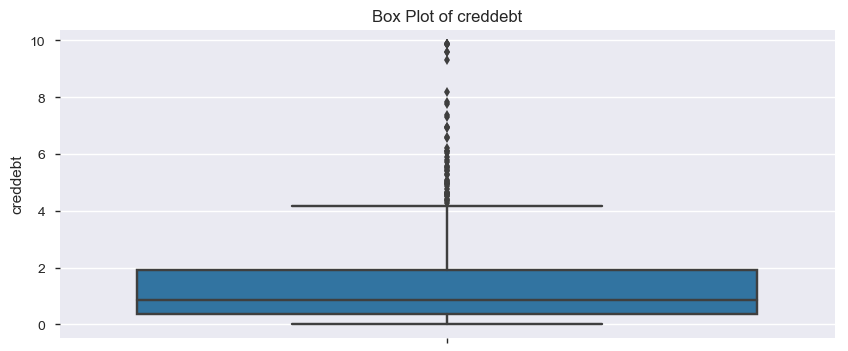

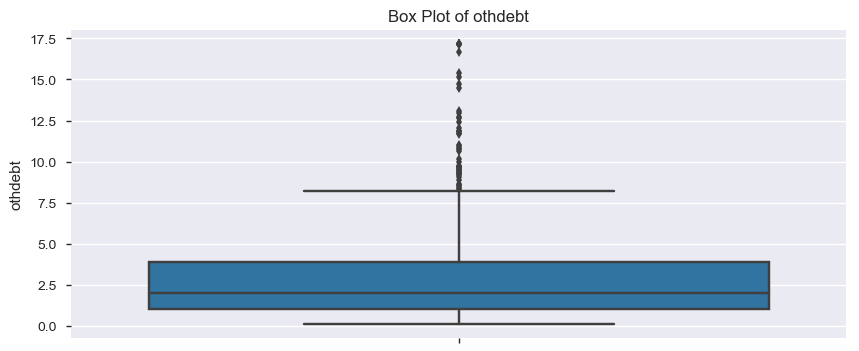

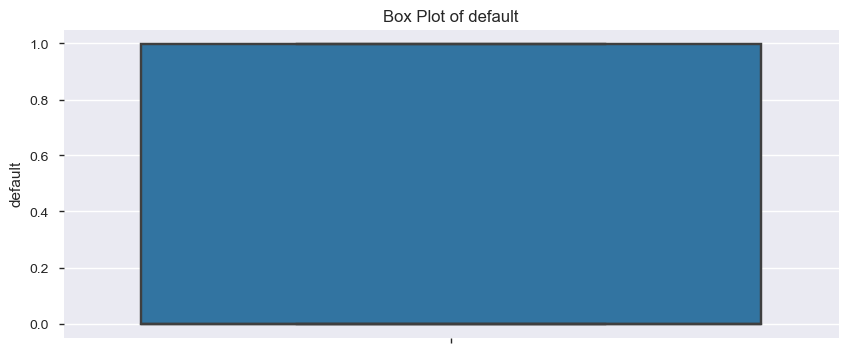

In [20]:
bp = PdfPages('BoxPlots with default Split.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=num_variable, data = bankloans_existing)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

bp = PdfPages('BoxPlots with Total View.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(y=num_variable, data = bankloans_existing)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

In [13]:
mjmj## Numerical Variable
tstats_df = pd.DataFrame()
for num_variable in numeric_var_names:
    tstats = stats.ttest_ind(bankloans_existing[bankloans_existing['default']==1][num_variable],bankloans_existing[bankloans_existing['default']==0][num_variable])
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)

print(tstats_df)

  Variable Name T-Statistic      P-Value
0           age    -3.67181  0.000259235
1            ed     3.04981   0.00237651
2        employ     -7.7948   2.3472e-14
3       address    -4.40472  1.22551e-05
4        income    -1.87974    0.0605604
5       debtinc     11.1754  8.65746e-27
6      creddebt     6.66875  5.24867e-11
7       othdebt     3.89121  0.000109296
8       default         inf            0


###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


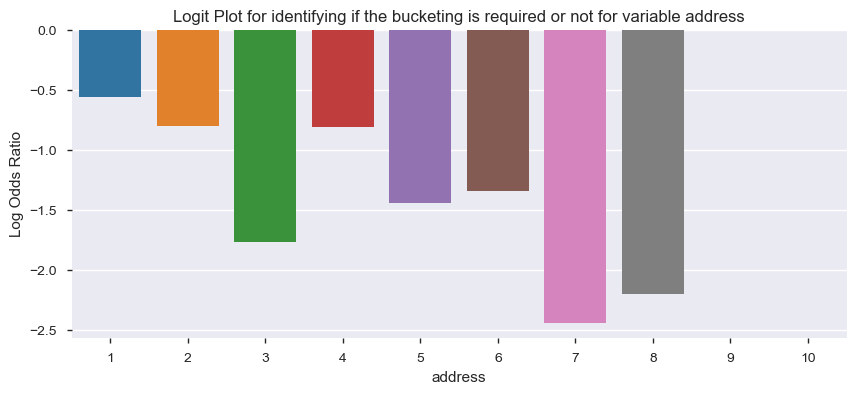

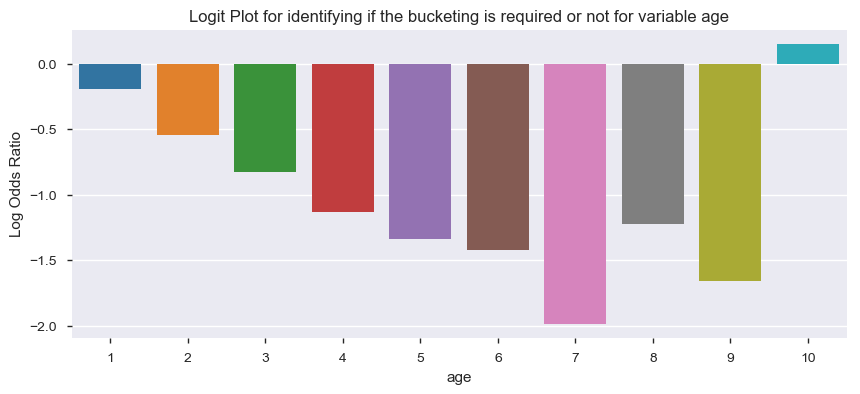

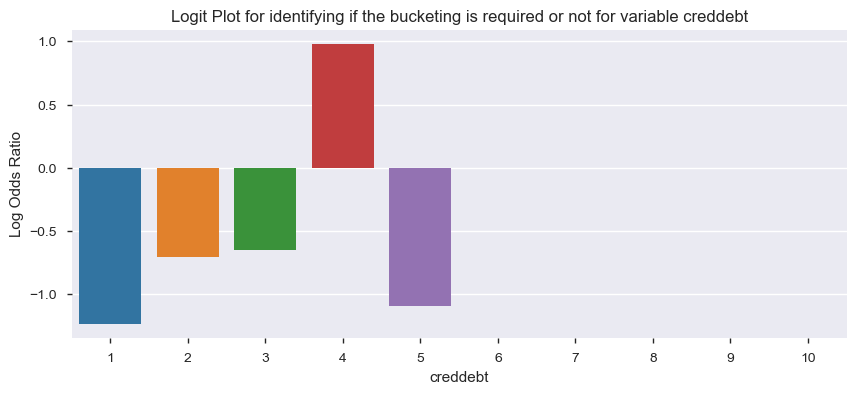

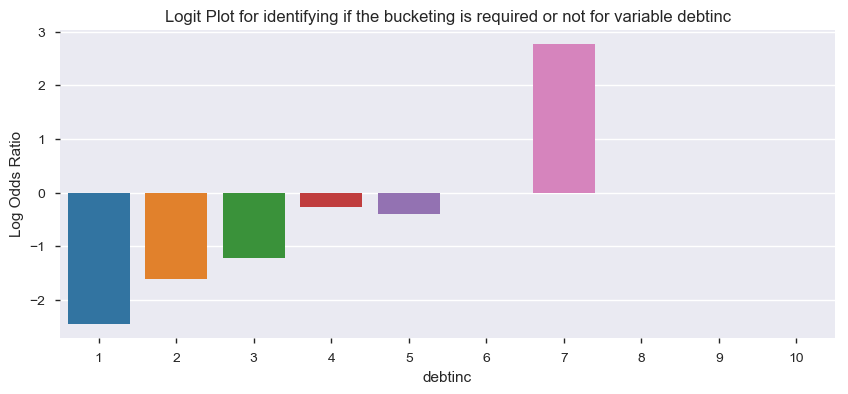

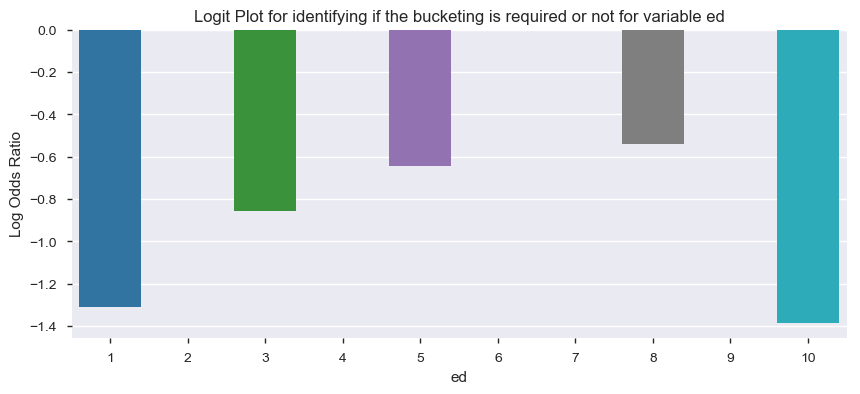

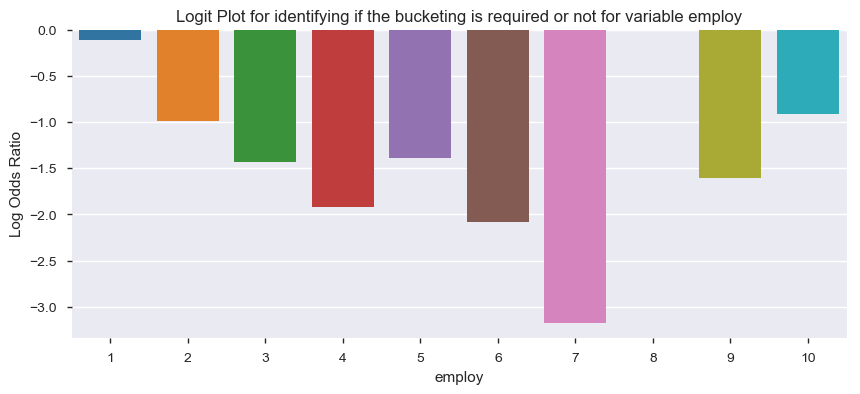

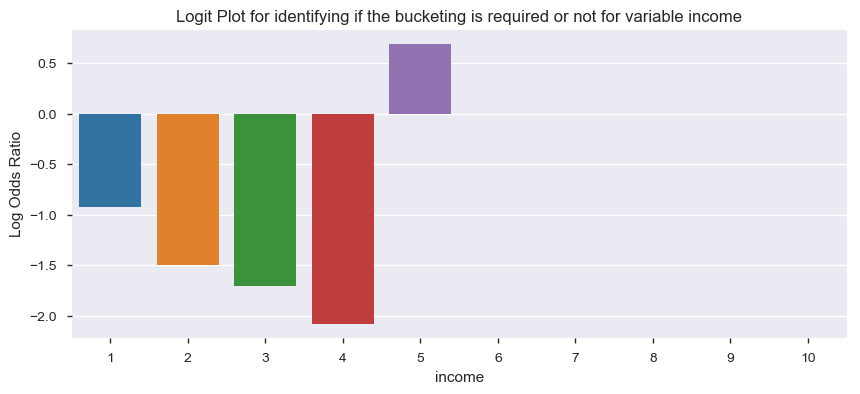

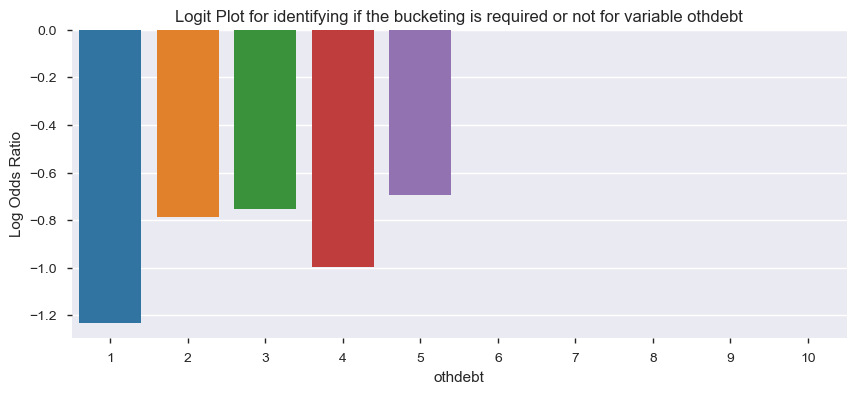

In [14]:
bp = PdfPages('Transformation Plots.pdf')
for num_variable in bankloans_existing.columns.difference(['default']):
    binned = pd.cut(bankloans_existing[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    ser = np.log(ser)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()

In [15]:
print('These variables need bucketing - creddebt, othdebt, debtinc, employ, income ')
bankloans_existing.columns

These variables need bucketing - creddebt, othdebt, debtinc, employ, income 


Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [16]:
bankloans_existing[['creddebt', 'othdebt', 'debtinc', 'employ','income' ]].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
creddebt,700.0,1.553553,2.117197,0.011696,0.170020,0.301390,0.440418,0.593059,0.854869,1.183471,1.615023,2.288026,3.621504,20.56131
othdebt,700.0,3.058209,3.287555,0.045584,0.562232,0.900747,1.165766,1.546101,1.987567,2.511054,3.258777,4.577926,7.036180,27.03360
debtinc,700.0,10.260571,6.827234,0.400000,2.900000,4.500000,5.800000,7.000000,8.600000,10.500000,12.900000,15.440000,19.610000,41.30000
employ,700.0,8.388571,6.658039,0.000000,1.000000,2.000000,4.000000,5.600000,7.000000,9.000000,11.000000,14.000000,18.000000,31.00000
income,700.0,45.601429,36.814226,14.000000,19.000000,22.000000,26.000000,29.000000,34.000000,40.400000,49.000000,61.000000,82.000000,446.00000


In [17]:
#bucekting
#bankloans_existing['creddebt_extreme'] = bankloans_existing['creddebt'].apply(lambda x: 0 if 162 < x < 221 else 1)
#bankloans_existing['othdebt_extreme'] = bankloans_existing['othdebt'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'] = bankloans_existing['debtinc'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'].value_counts()

###### 2.5 Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [20]:

somersd_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ')+str(num_variable), data=bankloans_existing)
    result = logreg.fit()
    summ = result.summary2()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(bankloans_existing['default'],y_score) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


,Variable Name,SomersD
0,address,0.222384
0,age,0.206329
0,creddebt,0.272378
0,debtinc,0.470506
0,ed,0.148302
0,employ,0.409138
0,income,0.200273
0,othdebt,0.173806


In [29]:
## Variance Inflation Factor assessment
X = pd.concat([bankloans_existing[bankloans_existing.columns.difference(['default'])],bankloans_existing['default']], axis=1)
features = "+".join(bankloans_existing.columns.difference(['default']))
X.head()

,address,age,creddebt,debtinc,ed,employ,income,othdebt,default
0,12.0,41.0,9.876748,9.3,3.0,17.0,176.0,5.008608,1.0
1,6.0,27.0,1.362202,17.3,1.0,10.0,31.0,4.000798,0.0
2,14.0,40.0,0.856075,5.5,1.0,15.0,55.0,2.168925,0.0
3,14.0,41.0,2.658720,2.9,1.0,15.0,120.0,0.821280,0.0
4,0.0,24.0,1.787436,17.3,2.0,2.0,28.0,3.056564,1.0


In [22]:
features

'address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [19]:
a,b = dmatrices(formula_like='default ~ '+ 'address+age+creddebt+debtinc+ed+employ+othdebt', data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

   VIF Factor   features
0   34.360143  Intercept
1    1.563286    address
2    1.995852        age
3    1.959823   creddebt
4    2.072643    debtinc
5    1.170277         ed
6    2.008810     employ
7    2.567415    othdebt


In [30]:
#Train and Test split

train_features = X.columns.difference(['default'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_X.columns

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt', 'default'],
      dtype='object')

In [31]:
logreg = sm.logit(formula='default ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.425415
         Iterations 7


In [ ]:
dir(result)

In [32]:
logreg = sm.logit(formula='default ~ address+debtinc+employ+othdebt' , data=train_X)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.464654
         Iterations 7


In [33]:
 result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.208     
Dependent Variable: default          AIC:              465.3605  
Date:               2018-08-02 14:11 BIC:              486.3325  
No. Observations:   490              Log-Likelihood:   -227.68   
Df Model:           4                LL-Null:          -287.47   
Df Residuals:       485              LLR p-value:      6.5506e-25
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.0362    0.2870  -3.6105  0.0003  -1.5987  -0.4737
address       -0.0446    0.0199  -2.2350  0.0254  -0.0836  -0.0055
debtinc        0.0933    0.0230   4.0595  0.0000   0.0483   0.1383
employ        -0.1667    0.0279  -5.9726  0.0000  -0.2214  -0.1120
othdebt        0.1556    0.0594   2.6176  0.0089   0.0391   0.2721
=================================================================

"""

In [34]:
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.6004947174241153
The Gini Index for the model built on the Test Data is :  0.7021168715933579


In [41]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
357,1.0,0.664441
649,0.0,0.509366
291,0.0,0.103195
420,1.0,0.442322
177,0.0,0.210984


In [40]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
158,1.0,0.267778
500,0.0,0.442589
396,0.0,0.173930
155,0.0,0.307507
321,1.0,0.500769


In [29]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [33]:
roc_like_df

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,1.000000,0.084270
0,0.040816,0.992537,0.174157
0,0.061224,0.977612,0.221910
0,0.081633,0.970149,0.286517
0,0.102041,0.955224,0.356742
0,0.122449,0.925373,0.421348
0,0.142857,0.917910,0.471910
0,0.163265,0.902985,0.497191
0,0.183673,0.880597,0.544944


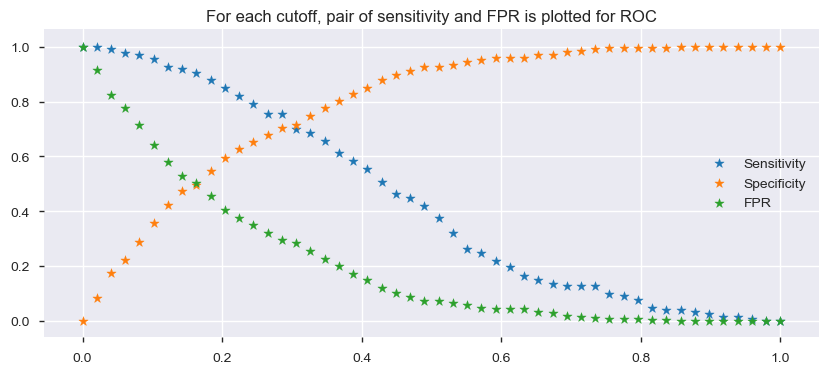

In [34]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()                

In [26]:
#ROC curve will be drawn b/w Sensitivity vs FPR

Model prediction Accuracy: 0.8006875733691095


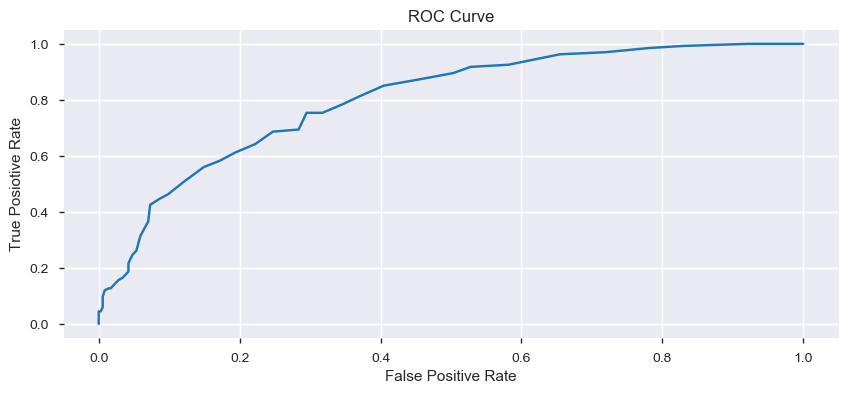

In [38]:
plt.subplots(figsize=(10,4))
plt.plot( 1-roc_like_df['specificity'],roc_like_df['sensitivity'])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Posiotive Rate')
print('Model prediction Accuracy:',metrics.auc(1-roc_like_df['specificity'],roc_like_df['sensitivity']))

In [34]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [35]:
roc_like_df

,cutoff,sensitivity,specificity,total
0,0.000000,1.000000,0.000000,1.000000
0,0.020408,1.000000,0.084270,1.084270
0,0.040816,0.992537,0.174157,1.166695
0,0.061224,0.977612,0.221910,1.199522
0,0.081633,0.970149,0.286517,1.256666
0,0.102041,0.955224,0.356742,1.311965
0,0.122449,0.925373,0.421348,1.346721
0,0.142857,0.917910,0.471910,1.389821
0,0.163265,0.902985,0.497191,1.400176
0,0.183673,0.880597,0.544944,1.425541


In [36]:
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.285714,0.753731,0.705056,1.458788


In [50]:
from sklearn.metrics import confusion_matrix
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
print('Train Data Confusion Matrix \n',confusion_matrix(train_predict['actual'],train_predict['predicted']))
print('Test Data Confusion Matrix \n',confusion_matrix(test_predict['actual'],test_predict['predicted']))

# (117+236)/(117+236+120+17)

Train Data Confusion Matrix 
 [[252 104]
 [ 33 101]]
Test Data Confusion Matrix 
 [[130  31]
 [ 11  38]]


In [49]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7204081632653061
The overall accuracy score for the Test Data  is :  0.8


In [41]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
#test['Deciles']=pd.qcut(test['prob'],10, labels=False)
train_predict.head()

,actual,prob,predicted,Deciles
357,1.0,0.668742,1,9
649,0.0,0.511699,1,8
291,0.0,0.101246,0,2
420,1.0,0.444934,1,7
177,0.0,0.209997,0,4


In [46]:
test_predict['Deciles']=pd.qcut(test_predict['prob'],10,labels=False)
test_predict.head()

,actual,prob,predicted,Deciles
158,1.0,0.266069,0,6
500,0.0,0.444936,1,8
396,0.0,0.171193,0,4
155,0.0,0.306464,1,6
321,1.0,0.509099,1,8


In [42]:
df = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)

In [47]:
df_test=test_predict[['Deciles','actual']].groupby(test_predict.Deciles).sum().sort_index(ascending=False)

In [43]:
df

,Deciles,actual
Deciles,,
9,441,32.0
8,392,30.0
7,343,19.0
6,294,13.0
5,245,17.0
4,196,9.0
3,147,5.0
2,98,5.0
1,49,4.0


In [50]:
df_test

,Deciles,actual
Deciles,,
9,189,15.0
8,168,14.0
7,147,8.0
6,126,2.0
5,105,4.0
4,84,2.0
3,63,3.0
2,42,1.0
1,21,0.0


In [44]:
train_predict[['Deciles','actual']].groupby(train_predict.Deciles).count().sort_index(ascending=False)

,Deciles,actual
Deciles,,
9,49,49
8,49,49
7,49,49
6,49,49
5,49,49
4,49,49
3,49,49
2,49,49
1,49,49


In [56]:
test_predict['Deciles']=pd.qcut(test_predict['prob'],10, labels=False)
df1 = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).sum().sort_index(ascending=False)

In [57]:
df1

,Deciles,actual
Deciles,,
9,189,15.0
8,168,14.0
7,147,8.0
6,126,2.0
5,105,4.0
4,84,2.0
3,63,3.0
2,42,1.0
1,21,0.0


In [58]:
new_cust_prob = pd.DataFrame(result.predict(bankloans_new))
new_cust_prob.columns = ['prob1']
bankloans_new1=pd.concat([bankloans_new, new_cust_prob.prob1], axis=1)

In [59]:
new_cust_prob.head(5)

,prob1
700,0.056888
701,0.139502
702,0.224735
703,0.126669
704,0.305974


In [60]:
bankloans_new1.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob1
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.056888
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.139502
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.224735
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.126669
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.305974


In [61]:
bankloans_new1['predicted'] = bankloans_new1['prob1'].apply(lambda x: 1 if x > 0.29 else 0)

# DECISION TREES

In [63]:
# Decision Trees
import sklearn.tree as dt
import sklearn.ensemble as en

In [66]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.grid_search import GridSearchCV

In [65]:
X.columns

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt', 'default'],
      dtype='object')

In [67]:
features = X.columns.difference(['default'])
features

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [68]:
from sklearn.cross_validation import train_test_split
train_X, test_X, train_y, test_y = train_test_split( X[features],
                                                  X['default'],
                                                  test_size = 0.7,
                                                  random_state = 142 )

In [69]:
clf_tree = DecisionTreeClassifier( max_depth = 3 )
clf_tree.fit( train_X, train_y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [70]:
dir(clf_tree)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_get_param_names',
 '_validate_X_predict',
 'apply',
 'class_weight',
 'classes_',
 'criterion',
 'decision_path',
 'feature_importances_',
 'fit',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_classes_',
 'n_features_',
 'n_outputs_',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'presort',

In [71]:
pd.DataFrame(clf_tree.predict_proba(train_X))

,0,1
0,0.968421,0.031579
1,0.568627,0.431373
2,0.968421,0.031579
3,0.568627,0.431373
4,0.968421,0.031579
5,0.568627,0.431373
6,0.968421,0.031579
7,1.000000,0.000000
8,0.111111,0.888889
9,0.968421,0.031579


In [72]:
tree_train_pred = pd.DataFrame( { 'actual':  train_y,
                            'predicted': clf_tree.predict( train_X ) } )

In [73]:
tree_train_pred.head(10)

,actual,predicted
536,0.0,0.0
346,0.0,0.0
406,0.0,0.0
123,1.0,0.0
207,0.0,0.0
473,0.0,0.0
46,0.0,0.0
53,0.0,0.0
413,1.0,1.0
512,0.0,0.0


In [74]:
tree_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': clf_tree.predict( test_X ) } )

In [75]:
tree_test_pred.head(10)

,actual,predicted
43,0.0,0.0
477,0.0,0.0
131,0.0,0.0
192,1.0,0.0
561,0.0,0.0
80,1.0,1.0
48,1.0,0.0
478,0.0,0.0
340,0.0,0.0
349,0.0,0.0


In [76]:
metrics.accuracy_score( tree_train_pred.actual, tree_train_pred.predicted )

0.819047619047619

In [77]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.7489795918367347

Text(0.5,28.3611,'Predicted label')

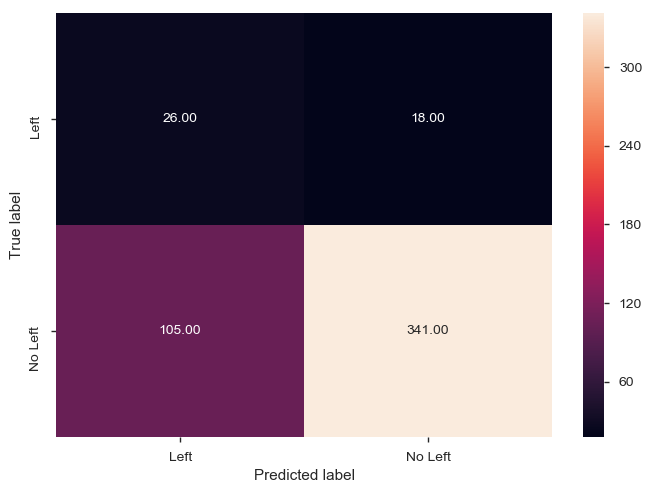

In [78]:
tree_cm = metrics.confusion_matrix( tree_test_pred.predicted,
                                 tree_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True, fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [79]:
#Fine Tuning the parameters
param_grid = {'max_depth': np.arange(3, 12)}

In [80]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
tree.fit( train_X, train_y )

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [81]:
tree.best_params_

{'max_depth': 3}

In [82]:
tree.best_score_

0.7142857142857143

In [83]:
#Building Final Decision Tree Model
train_X.head()

,address,age,creddebt,debtinc,ed,employ,income,othdebt
536,7.0,34.0,0.295137,1.7,2.0,9.0,27.0,0.163863
346,0.0,24.0,0.358663,4.3,2.0,3.0,19.0,0.458337
406,2.0,29.0,1.632120,6.7,1.0,12.0,40.0,1.047880
123,4.0,31.0,1.092454,12.7,1.0,2.0,22.0,1.701546
207,6.0,26.0,0.143700,1.0,2.0,6.0,30.0,0.160936


In [84]:
clf_tree = DecisionTreeClassifier( max_depth = 5 )
clf_tree.fit( train_X, train_y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [85]:
tree_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': clf_tree.predict( test_X ) } )

In [86]:
tree_test_pred.sample( n = 10 )

,actual,predicted
216,0.0,0.0
474,0.0,0.0
337,0.0,0.0
8,1.0,0.0
667,0.0,1.0
25,0.0,1.0
421,0.0,0.0
558,1.0,0.0
271,0.0,0.0
66,1.0,0.0


In [87]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.7081632653061225

Text(0.5,28.3611,'Predicted label')

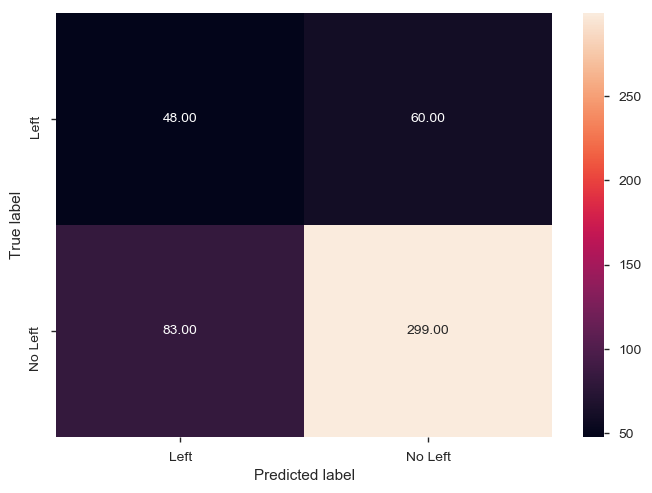

In [88]:
tree_cm = metrics.confusion_matrix( tree_test_pred.predicted,
                                 tree_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
#Generate Rules from Decision Trees
#To create a decision tree visualization graph.
#Install GraphViz (As per the OS and version you are using)
#pip install pydotplus
#Add the path to environmental variables
#Note: The notebook needs a restart.

In [89]:
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [90]:
export_graphviz( clf_tree,
              out_file = "hr_tree.odt",
              feature_names = train_X.columns )

In [91]:
import pydotplus as pdot

chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'hr_tree.odt' )

In [92]:
chd_tree_graph.write_jpg( 'hr_tree.jpg' )

True

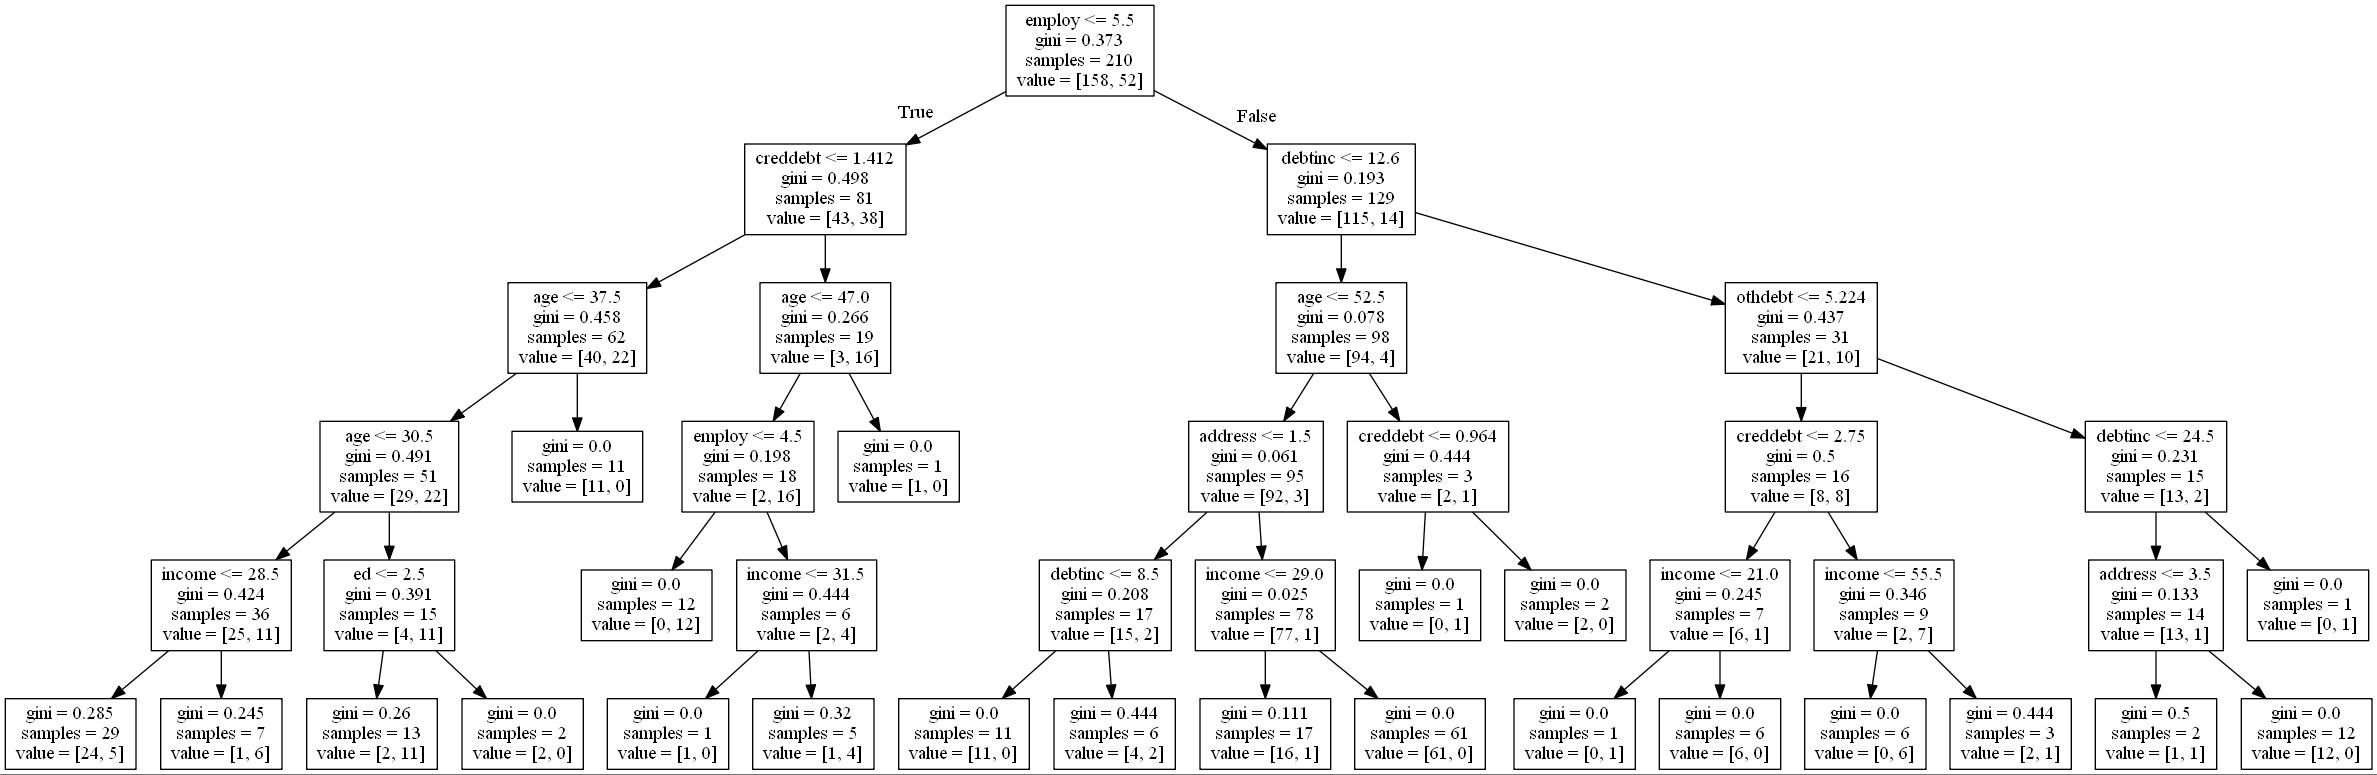

In [93]:
from IPython.display import Image
Image(filename='hr_tree.jpg')